In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=columns, na_values='?')

In [3]:
print(f"\nDataset shape: {data.shape}")


Dataset shape: (303, 14)


In [4]:
print(f"\nFirst 5 rows:")
print(data.head())


First 5 rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  


In [5]:
print(f"\nDataset info:")
print(data.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None


In [6]:
# Check missing values
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [7]:
# Statistical summary
print("\nStatistical Summary:")
print(data.describe())


Statistical Summary:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  275.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  299.000000   
mean     0.990099  149.607261    0.326733    1.039604    1.600660    0.672241   
std  

In [8]:
# Target distribution
print("\nTarget Distribution (0=No Disease, >0=Disease):")
print(data['target'].value_counts().sort_index())


Target Distribution (0=No Disease, >0=Disease):
target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


In [9]:
data['target'] = (data['target'] > 0).astype(int)

# Handle missing values
print(f"Rows before dropping missing values: {len(data)}")
data = data.dropna()
print(f"Rows after dropping missing values: {len(data)}")

Rows before dropping missing values: 303
Rows after dropping missing values: 297


In [10]:
# Check binary target distribution
print("\nBinary Target Distribution:")
print(data['target'].value_counts())
print(f"\nClass balance: {data['target'].value_counts(normalize=True)}")


Binary Target Distribution:
target
0    160
1    137
Name: count, dtype: int64

Class balance: target
0    0.538721
1    0.461279
Name: proportion, dtype: float64


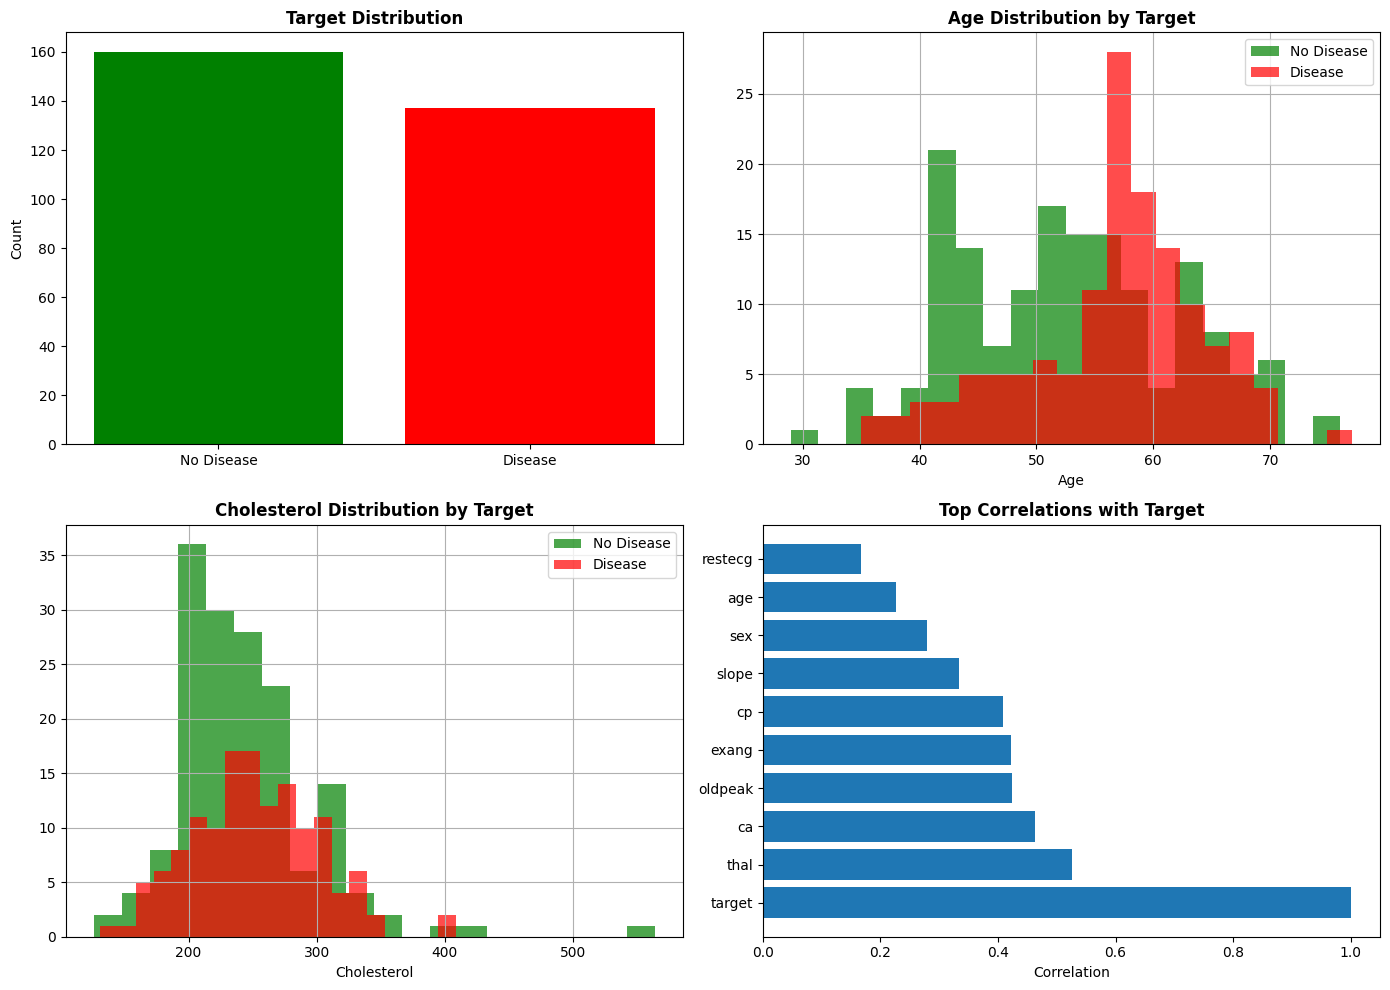

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Target distribution
axes[0, 0].bar(['No Disease', 'Disease'], data['target'].value_counts().values, color=['green', 'red'])
axes[0, 0].set_title('Target Distribution', fontweight='bold')
axes[0, 0].set_ylabel('Count')

# Age distribution by target
data[data['target']==0]['age'].hist(ax=axes[0, 1], bins=20, alpha=0.7, label='No Disease', color='green')
data[data['target']==1]['age'].hist(ax=axes[0, 1], bins=20, alpha=0.7, label='Disease', color='red')
axes[0, 1].set_title('Age Distribution by Target', fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].legend()

# Cholesterol distribution
data[data['target']==0]['chol'].hist(ax=axes[1, 0], bins=20, alpha=0.7, label='No Disease', color='green')
data[data['target']==1]['chol'].hist(ax=axes[1, 0], bins=20, alpha=0.7, label='Disease', color='red')
axes[1, 0].set_title('Cholesterol Distribution by Target', fontweight='bold')
axes[1, 0].set_xlabel('Cholesterol')
axes[1, 0].legend()

# Correlation heatmap
correlation = data.corr()
top_corr = correlation.nlargest(10, 'target')['target']
axes[1, 1].barh(range(len(top_corr)), top_corr.values)
axes[1, 1].set_yticks(range(len(top_corr)))
axes[1, 1].set_yticklabels(top_corr.index)
axes[1, 1].set_title('Top Correlations with Target', fontweight='bold')
axes[1, 1].set_xlabel('Correlation')

plt.tight_layout()
plt.show()

In [12]:
X = data.drop('target', axis=1)
y = data['target']

print("Features and target separated!")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature names:")
print(list(X.columns))

Features and target separated!

Feature matrix shape: (297, 13)
Target vector shape: (297,)

Feature names:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split completed!")
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Data split completed!

Training set size: 237 samples
Test set size: 60 samples

Training set class distribution:
target
0    128
1    109
Name: count, dtype: int64

Test set class distribution:
target
0    32
1    28
Name: count, dtype: int64


In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Feature scaling completed!")
print(f"\nOriginal data (first sample):")
print(X_train.iloc[0])

Feature scaling completed!

Original data (first sample):
age          54.0
sex           1.0
cp            4.0
trestbps    124.0
chol        266.0
fbs           0.0
restecg       2.0
thalach     109.0
exang         1.0
oldpeak       2.2
slope         2.0
ca            1.0
thal          7.0
Name: 55, dtype: float64


In [15]:
print(f"\nScaled data (first sample):")
print(X_train_scaled.iloc[0])


Scaled data (first sample):
age        -0.085668
sex         0.693722
cp          0.853348
trestbps   -0.462582
chol        0.312737
fbs        -0.450606
restecg     1.023523
thalach    -1.827448
exang       1.374861
oldpeak     0.967117
slope       0.672972
ca          0.349404
thal        1.131548
Name: 0, dtype: float64


In [16]:
print(f"\nScaled data statistics:")
print(X_train_scaled.describe())


Scaled data statistics:
                age           sex            cp      trestbps          chol  \
count  2.370000e+02  2.370000e+02  2.370000e+02  2.370000e+02  2.370000e+02   
mean  -2.623312e-16  7.495177e-18  6.933038e-17 -6.052355e-16 -2.599889e-16   
std    1.002116e+00  1.002116e+00  1.002116e+00  1.002116e+00  1.002116e+00   
min   -2.304616e+00 -1.441500e+00 -2.290332e+00 -2.140621e+00 -2.326280e+00   
25%   -7.513526e-01 -1.441500e+00 -1.945456e-01 -6.863203e-01 -7.051694e-01   
50%    1.362266e-01  6.937218e-01 -1.945456e-01 -1.269740e-01 -1.208157e-01   
75%    8.019109e-01  6.937218e-01  8.533477e-01  4.323724e-01  5.200883e-01   
max    2.466122e+00  6.937218e-01  8.533477e-01  3.788450e+00  5.930072e+00   

                fbs       restecg       thalach         exang       oldpeak  \
count  2.370000e+02  2.370000e+02  2.370000e+02  2.370000e+02  2.370000e+02   
mean  -4.684485e-17  6.933038e-17 -4.047395e-16  7.495177e-17  2.998071e-17   
std    1.002116e+00  1.002

In [17]:
print("="*60)
print("TRAINING: SUPPORT VECTOR MACHINE (SVM)")
print("="*60)

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Cross-validation
cv_scores_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("✓ SVM Model trained successfully!")
print(f"\nCross-validation scores: {cv_scores_svm}")
print(f"Mean CV Accuracy: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std():.4f})")


TRAINING: SUPPORT VECTOR MACHINE (SVM)
✓ SVM Model trained successfully!

Cross-validation scores: [0.9375     0.875      0.85106383 0.72340426 0.68085106]
Mean CV Accuracy: 0.8136 (+/- 0.0962)


In [18]:
print("="*60)
print("TRAINING: LOGISTIC REGRESSION")
print("="*60)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("✓ Logistic Regression Model trained successfully!")
print(f"\nCross-validation scores: {cv_scores_lr}")
print(f"Mean CV Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")

# Feature coefficients
print(f"\nTop 5 Most Important Features (by coefficient):")
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_[0]})
print(coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head())


TRAINING: LOGISTIC REGRESSION
✓ Logistic Regression Model trained successfully!

Cross-validation scores: [0.9375     0.875      0.80851064 0.76595745 0.72340426]
Mean CV Accuracy: 0.8221 (+/- 0.0764)

Top 5 Most Important Features (by coefficient):
    Feature  Coefficient
11       ca     0.958461
12     thal     0.738613
2        cp     0.507960
1       sex     0.484582
9   oldpeak     0.444296


In [19]:
print("="*60)
print("TRAINING: RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("✓ Random Forest Model trained successfully!")
print(f"\nCross-validation scores: {cv_scores_rf}")
print(f"Mean CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

# Feature importance
print(f"\nTop 5 Most Important Features:")
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feat_imp_df.head())


TRAINING: RANDOM FOREST
✓ Random Forest Model trained successfully!

Cross-validation scores: [0.91666667 0.83333333 0.82978723 0.76595745 0.74468085]
Mean CV Accuracy: 0.8181 (+/- 0.0603)

Top 5 Most Important Features:
    Feature  Importance
2        cp    0.142050
12     thal    0.121571
7   thalach    0.121296
9   oldpeak    0.114585
11       ca    0.097477


In [20]:
print("="*60)
print("TRAINING: XGBOOST")
print("="*60)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("✓ XGBoost Model trained successfully!")
print(f"\nCross-validation scores: {cv_scores_xgb}")
print(f"Mean CV Accuracy: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})")

# Feature importance
print(f"\nTop 5 Most Important Features:")
feat_imp_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feat_imp_xgb.head())



TRAINING: XGBOOST
✓ XGBoost Model trained successfully!

Cross-validation scores: [0.91666667 0.83333333 0.80851064 0.70212766 0.74468085]
Mean CV Accuracy: 0.8011 (+/- 0.0741)

Top 5 Most Important Features:
   Feature  Importance
12    thal    0.249334
2       cp    0.180229
11      ca    0.121676
10   slope    0.089723
1      sex    0.065488


In [21]:
print("="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60)

models = {
    'SVM': svm_model,
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Print results table
print(f"\n{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*73)
for name, metrics in results.items():
    print(f"{name:<25} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
          f"{metrics['recall']:<12.4f} {metrics['f1_score']:<12.4f}")

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['f1_score'])
print(f"\n🏆 Best Model: {best_model[0]} (F1-Score: {best_model[1]['f1_score']:.4f})")

MODEL EVALUATION ON TEST SET

Model                     Accuracy     Precision    Recall       F1-Score    
-------------------------------------------------------------------------
SVM                       0.8500       0.8800       0.7857       0.8302      
Logistic Regression       0.8333       0.8462       0.7857       0.8148      
Random Forest             0.8667       0.8846       0.8214       0.8519      
XGBoost                   0.8667       0.8846       0.8214       0.8519      

🏆 Best Model: Random Forest (F1-Score: 0.8519)


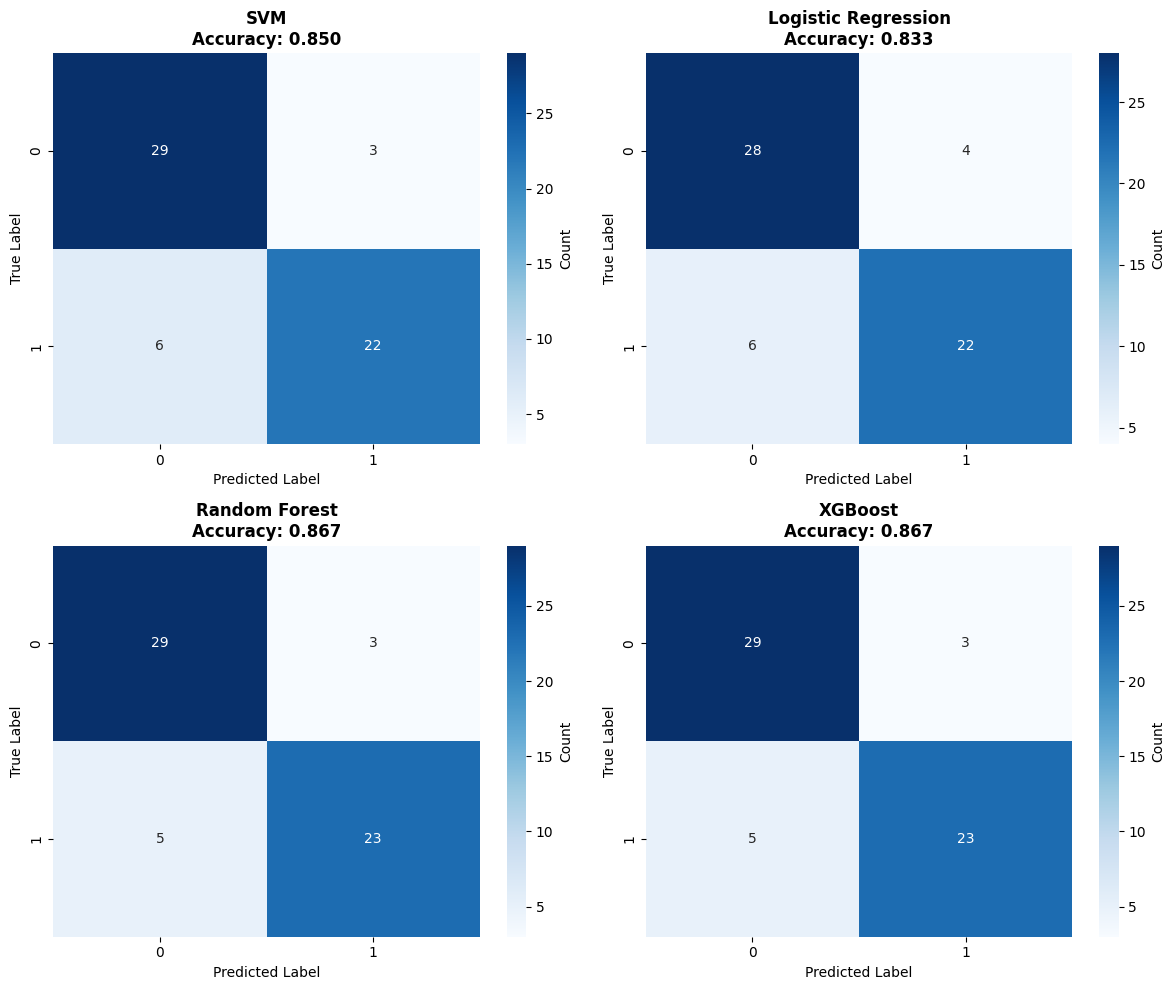

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    y_pred = results[name]['predictions']
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{name}\nAccuracy: {results[name]["accuracy"]:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

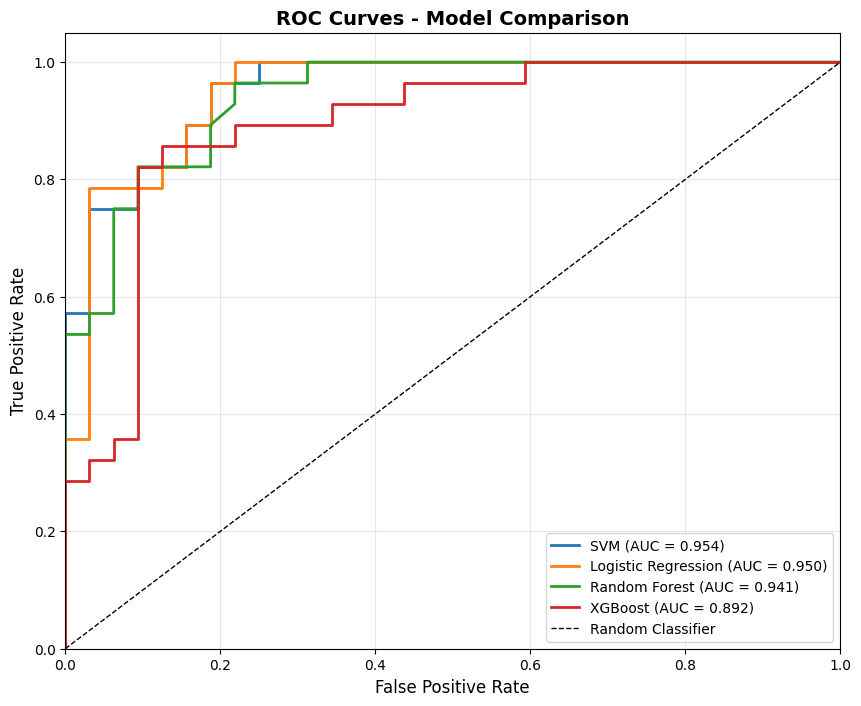

In [23]:
plt.figure(figsize=(10, 8))

for name in models.keys():
    y_pred_proba = results[name]['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

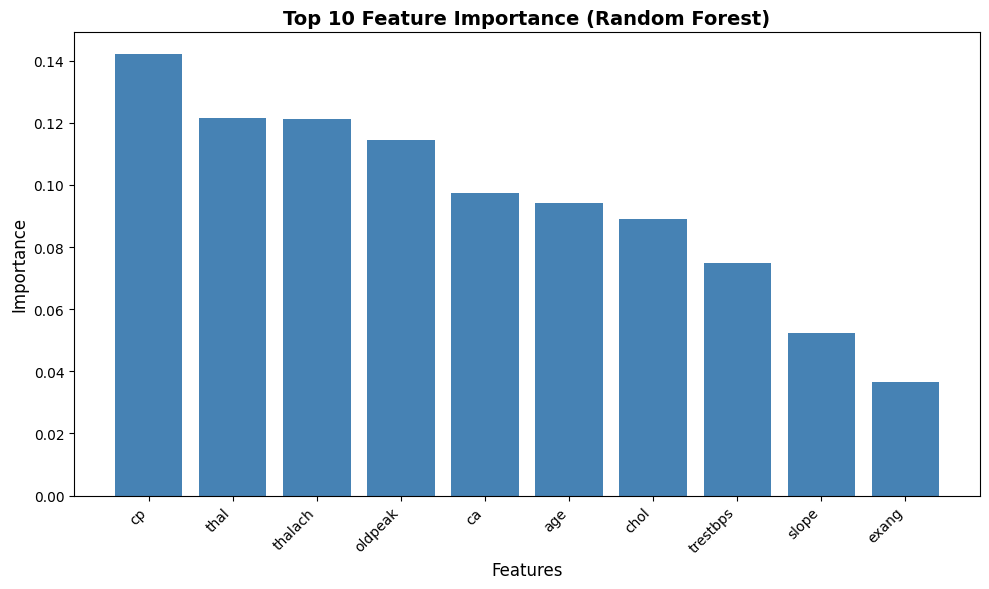

In [24]:
plt.figure(figsize=(10, 6))

# Use Random Forest feature importance
importance = rf_model.feature_importances_
indices = np.argsort(importance)[::-1][:10]

plt.bar(range(len(indices)), importance[indices], color='steelblue')
plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top 10 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
print(f"\nTop 10 Features:")
for i, idx in enumerate(indices, 1):
    print(f"{i}. {X.columns[idx]}: {importance[idx]:.4f}")


Top 10 Features:
1. cp: 0.1420
2. thal: 0.1216
3. thalach: 0.1213
4. oldpeak: 0.1146
5. ca: 0.0975
6. age: 0.0942
7. chol: 0.0892
8. trestbps: 0.0749
9. slope: 0.0523
10. exang: 0.0365


In [26]:
print("="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

for name, model in models.items():
    print(f"\n{name}:")
    print("-"*60)
    y_pred = results[name]['predictions']
    print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))

DETAILED CLASSIFICATION REPORTS

SVM:
------------------------------------------------------------
              precision    recall  f1-score   support

  No Disease       0.83      0.91      0.87        32
     Disease       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


Logistic Regression:
------------------------------------------------------------
              precision    recall  f1-score   support

  No Disease       0.82      0.88      0.85        32
     Disease       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60


Random Forest:
------------------------------------------------------------
              precision    recall  f1-score   support

  No Disease       0.85      0.9

In [27]:
print("="*60)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*60)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_tuned = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_tuned, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"\n✓ Hyperparameter tuning completed!")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
y_pred_tuned = grid_search.best_estimator_.predict(X_test_scaled)
print(f"\nTuned Model Test Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Original Model Test Accuracy: {results['Random Forest']['accuracy']:.4f}")


HYPERPARAMETER TUNING - RANDOM FOREST
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✓ Hyperparameter tuning completed!

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8475

Tuned Model Test Accuracy: 0.8333
Original Model Test Accuracy: 0.8667


In [28]:
print("="*60)
print("PREDICTION FOR NEW PATIENT")
print("="*60)

# Sample new patient data
new_patient = pd.DataFrame({
    'age': [63],
    'sex': [1],
    'cp': [3],
    'trestbps': [145],
    'chol': [233],
    'fbs': [1],
    'restecg': [0],
    'thalach': [150],
    'exang': [0],
    'oldpeak': [2.3],
    'slope': [0],
    'ca': [0],
    'thal': [1]
})

print("New Patient Data:")
print(new_patient)

# Scale the data
new_patient_scaled = scaler.transform(new_patient)

# Make prediction with best model (XGBoost)
prediction = xgb_model.predict(new_patient_scaled)[0]
probability = xgb_model.predict_proba(new_patient_scaled)[0]

print(f"\n{'='*60}")
print(f"PREDICTION RESULT:")
print(f"{'='*60}")
print(f"Diagnosis: {'DISEASE DETECTED' if prediction == 1 else 'NO DISEASE'}")
print(f"Probability of Disease: {probability[1]:.2%}")
print(f"Probability of No Disease: {probability[0]:.2%}")
print(f"Confidence: {max(probability):.2%}")
if probability[1] > 0.7:
    risk = 'HIGH'
elif probability[1] > 0.4:
    risk = 'MEDIUM'
else:
    risk = 'LOW'
print(f"Risk Level: {risk}")



PREDICTION FOR NEW PATIENT
New Patient Data:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   

   ca  thal  
0   0     1  

PREDICTION RESULT:
Diagnosis: NO DISEASE
Probability of Disease: 0.80%
Probability of No Disease: 99.20%
Confidence: 99.20%
Risk Level: LOW


In [29]:
import joblib

# Save the best model (XGBoost)
joblib.dump(xgb_model, 'xgboost_model.pkl')
print("✓ Saved: xgboost_model.pkl")

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("✓ Saved: scaler.pkl")

# Save results to CSV
results_df = pd.DataFrame(results).T
results_df = results_df.drop(['predictions', 'probabilities'], axis=1)
results_df.to_csv('model_results.csv')
print("✓ Saved: model_results.csv")

print("\n" + "="*60)
print("✓ ALL MODELS AND RESULTS SAVED SUCCESSFULLY!")
print("="*60)


✓ Saved: xgboost_model.pkl
✓ Saved: scaler.pkl
✓ Saved: model_results.csv

✓ ALL MODELS AND RESULTS SAVED SUCCESSFULLY!


In [30]:
print("\n" + "█"*60)
print("PROJECT SUMMARY")
print("█"*60)

print(f"\n📊 Dataset: Heart Disease")
print(f"   - Total samples: {len(data)}")
print(f"   - Features: {len(X.columns)}")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Test samples: {len(X_test)}")

print(f"\n🤖 Models Trained: {len(models)}")
for name in models.keys():
    print(f"   - {name}")

print(f"\n🏆 Best Model: {best_model[0]}")
print(f"   - Accuracy: {best_model[1]['accuracy']:.4f}")
print(f"   - Precision: {best_model[1]['precision']:.4f}")
print(f"   - Recall: {best_model[1]['recall']:.4f}")
print(f"   - F1-Score: {best_model[1]['f1_score']:.4f}")

print(f"\n📁 Files Generated:")
print(f"   - xgboost_model.pkl")
print(f"   - scaler.pkl")
print(f"   - model_results.csv")

print("\n⚠️  IMPORTANT REMINDERS:")
print("   • Medical predictions should be validated by professionals")
print("   • Regularly retrain models with new data")
print("   • Ensure compliance with healthcare regulations")
print("   • Document model limitations")


████████████████████████████████████████████████████████████
PROJECT SUMMARY
████████████████████████████████████████████████████████████

📊 Dataset: Heart Disease
   - Total samples: 297
   - Features: 13
   - Training samples: 237
   - Test samples: 60

🤖 Models Trained: 4
   - SVM
   - Logistic Regression
   - Random Forest
   - XGBoost

🏆 Best Model: Random Forest
   - Accuracy: 0.8667
   - Precision: 0.8846
   - Recall: 0.8214
   - F1-Score: 0.8519

📁 Files Generated:
   - xgboost_model.pkl
   - scaler.pkl
   - model_results.csv

⚠️  IMPORTANT REMINDERS:
   • Medical predictions should be validated by professionals
   • Regularly retrain models with new data
   • Ensure compliance with healthcare regulations
   • Document model limitations
